
Rigid Transformation Network (RXFM Net)
====

Single Subject Example
----

This notebook provides example code for [our MICCAI 2021 paper](https://arxiv.org/abs/2103.10255). It roughly recreates Figure 2, the single subject two-pose experiment. It has been slightly reformatted to provide better explainations, and to use the MNI152 subject instead of an HCP subject.

We'll first import the necessary libraries and variables, including the MNI152 standard filepath from nilearn. Our code expects to be running the notebook server from the repo root directory, but you can also change `src/` to the full physical path.

In [1]:
import sys
sys.path.append('src/')

import numpy as np
import torch
from nilearn.datasets import MNI152_FILE_PATH
from functools import partial

print(MNI152_FILE_PATH)

IMG_SIZE = [96,96,96]

import utils
import losses
import custom_image3d as ci3d
import rxfm_net

/data/vision/polina/shared_software/anaconda3-4.3.1/envs/rxfm/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


/data/vision/polina/shared_software/anaconda3-4.3.1/envs/rxfm/lib/python3.8/site-packages/nilearn/datasets/data/mni_icbm152_t1_tal_nlin_sym_09a_converted.nii.gz


After loading in the file, we'll scale and pad it to `[96,96,96]`, as well as rescaling the histogram using a simple quantile filter. We'll then create the second pose, with a known (chosen) transformation matrix. In other situations, `loader_dict` might be the output of a `DataLoader` object, but here we only have one.

In [2]:
with torch.no_grad():
    img_vol, _, _ = utils.load_scale_and_pad(MNI152_FILE_PATH, IMG_SIZE, initial_resize=[128,128,128], rescale=[96,96,96])

    print(img_vol.size())

    img_vol = img_vol.float()
    mask = (img_vol > 0).float()

    rx_train = 1
    ry_train = 1
    rz_train = 1
    tx_train = 5
    ty_train = 5
    tz_train = 5

    mat = ci3d.create_transform(
        rx=rx_train, ry=ry_train, rz=rz_train,
        tx=2.0*tx_train/IMG_SIZE[0], ty=2.0*ty_train/IMG_SIZE[1], tz=2.0*tz_train/IMG_SIZE[2]
    )
    
    mat = mat[np.newaxis,:,:]
    mat = mat[:,0:3,:]
    mat = torch.tensor(mat).float()

    print(mat)
    grids = torch.nn.functional.affine_grid(mat, [1,1] + IMG_SIZE)
    second_img_vol = torch.nn.functional.grid_sample(
      img_vol, grids, mode="bilinear"
    ).detach()
    second_mask = (second_img_vol > 0).float()

loader_dict = {
    "scan_1" : img_vol,
    "mask_1" : mask,
    "scan_2" : second_img_vol,
    "mask_2" : second_mask,
    "xfm_1to2" : mat
}


torch.Size([1, 1, 96, 96, 96])
tensor([[[ 0.2919, -0.4546,  0.8415,  0.1042],
         [ 0.8372, -0.3039, -0.4546,  0.1042],
         [ 0.4624,  0.8372,  0.2919,  0.1042]]])


/data/vision/polina/shared_software/anaconda3-4.3.1/envs/rxfm/lib/python3.8/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/data/vision/polina/shared_software/anaconda3-4.3.1/envs/rxfm/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Visualization
----
Let's visualize these images:

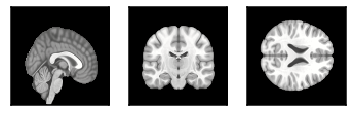

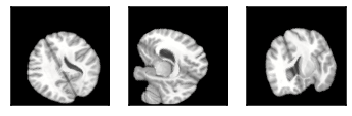

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

from nilearn import plotting
import seaborn_image as isns

def plotting_function(vol,x,y,z,ax):
    isns.imgplot( np.transpose(vol[x,:,:]), cbar=False, gray=True, ax=ax[0])
    isns.imgplot( np.transpose(vol[:,y,:]), cbar=False, gray=True, ax=ax[1])
    isns.imgplot( vol[:,:,z], cbar=False, gray=True, ax=ax[2])
    plt.show()

fig_end, ax_start = plt.subplots(1,3)
plotting_function(img_vol.numpy()[0,0,...],48,48,48,ax_start)
fig_end, ax_end = plt.subplots(1,3)
plotting_function(second_img_vol.numpy()[0,0,...],48,48,48,ax_end)


Training and torch cargo-culting
----
Defining some paramters for the network:

In [4]:
batch_size = 1
IMG_SIZE = [96,96,96,1]
loss_func_name = "xfm_6D"

n_conv_chan = 1
n_chan = 64
overfit = True 


In [5]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

print(f"using {device} as device")

using cuda:0 as device


In [6]:
net_obj = rxfm_net.RXFM_Net_Wrapper(IMG_SIZE[0:3], n_chan, masks_as_input=False)

if loss_func_name == "xfm_MSE":
    loss_func = partial( losses.xfm_loss_MSE, weight_R=1.0, weight_T=5.0)
elif loss_func_name == "xfm_6D":
    loss_func = partial( losses.xfm_loss_6D, weight_R=1.0, weight_T=5.0)
else:
    print("Loss function not recognized")
    exit(1)

net_obj = net_obj.to(device)
LR = 0.000025
optimizer = torch.optim.Adam(net_obj.parameters(), lr=LR)

compute... save... done
compute... save... done
compute... save... done
compute... save... done
compute... save... done
WARNING [spatial_mean]: pytorch reverses its axes because why not. Thus, pytorch(z,y,x) is the order output unless specified via:
 pytorch_order=False
 This order is NOT reversed (i.e. left ambiguous) in their affine_grid


/home/vivekg/rxfm-net/src/spatial_mean.py:31: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  coord_idx_tensor = torch.range(0, in_shape - 1)


Training Function and Loop
----

This is the main training function, and then the loop that runs it. We're only running for 100 epochs, but you can run it for much longer. For most seeds this seems to work, though there likely are some adversarial initializations.

In [7]:
def train_func( net_obj, optimizer, loss_func, loader_dict ):
    input_1 = loader_dict["scan_1"].to(device)
    input_2 = loader_dict["scan_2"].to(device)

    optimizer.zero_grad()

    #remember xfm is flipped during affine_grid
    # from
    # https://discuss.pytorch.org/t/unexpected-behaviour-for-affine-grid-and-grid-sample-with-3d-inputs/75010/5
    #net_obj MUST take both scans as input, and output a transform between them.
    # for rxfm net, the forward operator with only one scan should be implemented
    # separately!!! 
    xfm_1to2 = net_obj.forward((input_1,input_2))

    # XFM LOSS
    real_xfm_1to2 = loader_dict["xfm_1to2"].to(device)
    loss_val = loss_func( real_xfm_1to2, xfm_1to2 )

    loss_val.backward(retain_graph=True)
    optimizer.step()

    train_loss = loss_val.item()*batch_size

    print(real_xfm_1to2)
    print(xfm_1to2)

    del real_xfm_1to2
    del loss_val
    del xfm_1to2 #, dist_xfm_1to2
    del input_1, input_2
    torch.cuda.empty_cache()
    
    return train_loss

In [8]:
n_epochs = 100

for epoch in range(n_epochs):

    ##
    ## train loop
    ##
    
    print(epoch, flush=True)

    train_loss = 0
    #THIS WOULD USUALLY BE A LOADER, but we only have one datapoint anyway...
    #for d_idx,loader_dict in enumerate(train_loader):
    #    print(d_idx, flush=True)
    train_loss = train_func( net_obj, optimizer, loss_func, loader_dict )

    #train_loss = train_loss / len(dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss), flush=True)

0
tensor([[[ 0.2919, -0.4546,  0.8415,  0.1042],
         [ 0.8372, -0.3039, -0.4546,  0.1042],
         [ 0.4624,  0.8372,  0.2919,  0.1042]]], device='cuda:0')
tensor([[[ 0.2535, -0.5155,  0.8185,  0.0896],
         [ 0.8563, -0.2740, -0.4377,  0.0907],
         [ 0.4499,  0.8119,  0.3720,  0.1178]]], device='cuda:0',
       grad_fn=<CatBackward0>)
Epoch: 0 	Training Loss: 0.013504
1
tensor([[[ 0.2919, -0.4546,  0.8415,  0.1042],
         [ 0.8372, -0.3039, -0.4546,  0.1042],
         [ 0.4624,  0.8372,  0.2919,  0.1042]]], device='cuda:0')
tensor([[[ 0.2536, -0.5154,  0.8185,  0.0896],
         [ 0.8563, -0.2739, -0.4378,  0.0906],
         [ 0.4499,  0.8120,  0.3719,  0.1178]]], device='cuda:0',
       grad_fn=<CatBackward0>)
Epoch: 1 	Training Loss: 0.013469
2
tensor([[[ 0.2919, -0.4546,  0.8415,  0.1042],
         [ 0.8372, -0.3039, -0.4546,  0.1042],
         [ 0.4624,  0.8372,  0.2919,  0.1042]]], device='cuda:0')
tensor([[[ 0.2538, -0.5154,  0.8185,  0.0897],
         [ 0.8563

Interactive Demo
----

And now, the fun part: an interactive demo of the network rigidly registering things. 

In [14]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

tx_widget = widgets.FloatSlider(
    value=0.0, min=-10.0, max=10.0, step=0.1, description='Translation in X: (in vox)', continuous_update=False
)

ty_widget = widgets.FloatSlider(
    value=0.0, min=-10.0, max=10.0, step=0.1, description='Translation in Y (in vox):', continuous_update=False
)

tz_widget = widgets.FloatSlider(
    value=0.0, min=-10.0, max=10.0, step=0.1, description='Translation in Z (in vox):', continuous_update=False
)

rx_widget = widgets.FloatSlider(
    value=0.0, min=-1, max=1, step=0.1, description='Rotation X-axis (in pi rad):', continuous_update=False
)

ry_widget = widgets.FloatSlider(
    value=0.0, min=-1, max=1, step=0.1, description='Rotation Y-axis (in pi rad):', continuous_update=False
)

rz_widget = widgets.FloatSlider(
    value=0.0, min=-1, max=1, step=0.1, description='Rotation Z-axis (in pi rad):', continuous_update=False
)

In [15]:
vol = img_vol[0,0,...].cpu()
#this jupyter magick makes the notebook update the current plot instead of building a new plot each time...I think
#%matplotlib widget
%matplotlib inline
from pytorch3d import transforms as pt3d_xfms

net_obj.eval()

def interactive_funky_times(vol,rx,ry,rz,tx,ty,tz):
    fig1, ax1 = plt.subplots(1,3)
    plotting_function(vol.detach().cpu().numpy(),48,48,48,ax1)

    mat = ci3d.create_transform(rx=rx*np.pi, ry=ry*np.pi, rz=rz*np.pi, tx=2.0*tx/96, ty=2.0*ty/96, tz=2.0*tz/96)
    print("Starting Volume:")
    print("Selected Matrix:\n", mat)
    
    mat = mat[0:3,:]
    mat = torch.tensor(mat[np.newaxis,:,:],dtype=torch.float)
    vol = torch.tensor(vol[np.newaxis,np.newaxis,...],dtype=torch.float)
    grids = torch.nn.functional.affine_grid(mat, [1,1] + IMG_SIZE[0:3])
    moved_vol = torch.nn.functional.grid_sample(
      vol, grids, mode="bilinear"
    )

    print("Moved Volume:")
    fig2, ax2 = plt.subplots(1,3)
    plotting_function(moved_vol[0,0,...],48,48,48,ax2)
    
    xfm_1to2 = net_obj.forward((vol.to(device),moved_vol.to(device)))
    xfm_1to2 = xfm_1to2.cpu()
    #loss_val = loss_func( mat, xfm_1to2 )
    #loss_val = loss_val.mean().item()

    xfm_1to2 = xfm_1to2.cpu()
    print("Approx Matrix:\n",xfm_1to2.detach().numpy())
    #print("Loss val:",loss_val)
    print("Approx Moved Vol")
    grids = torch.nn.functional.affine_grid(xfm_1to2, [1,1] + IMG_SIZE[0:3])
    moved_vol = torch.nn.functional.grid_sample(
      vol, grids, mode="bilinear"
    )

    fig3, ax3 = plt.subplots(1,3)
    plotting_function(moved_vol.detach().numpy()[0,0,...],48,48,48,ax3)

    rot_real = mat[:,0:3,0:3].detach().cpu().numpy()
    trans_real = mat[:,0:3,3:].detach().cpu().numpy()
    
    rot_approx = xfm_1to2[:,0:3,0:3].detach().cpu().numpy()
    trans_approx = xfm_1to2[:,0:3,3:].detach().cpu().numpy()

    print(trans_real)
    print(trans_approx)
    
    angles_real = pt3d_xfms.matrix_to_euler_angles(torch.tensor(rot_real[0,:,:]), convention="XYZ")
    angles_approx = pt3d_xfms.matrix_to_euler_angles(torch.tensor(rot_approx[0,:,:]), convention="XYZ")

    print(angles_real)
    print(angles_approx)
    
    print("angular abs. error (mean degrees)", np.rad2deg(np.mean(np.abs(np.array(angles_real) - np.array(angles_approx)))))
    print("trans error", np.linalg.norm(trans_real - trans_approx))

#interact_manual(
interact(
    interactive_funky_times,
    vol=widgets.fixed(vol),
    rx=rx_widget, ry=ry_widget, rz=rz_widget,
    tx=tx_widget, ty=ty_widget, tz=tz_widget
)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Rotation X-axis (in pi rad)…

<function __main__.interactive_funky_times(vol, rx, ry, rz, tx, ty, tz)>